# Calibration of General Simulation Model

This notebook implements a Bayesian approach to finding model parameters that seem reasonable.

Model specific variables are imported in the file gsm_metadata.pkl. This file is a Python dictionary that was created when the model was created. 

In [1]:
%matplotlib notebook

import os
import datetime as dt
import pickle, joblib


# Standard data science libraries
import pandas as pd
import numpy as np
import scipy.stats as ss
import scipy.optimize as so 
import scipy.interpolate as si

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-notebook')

# Options for pandas
pd.options.display.max_columns = 20
pd.options.display.max_rows = 200

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython.display import Image
from IPython.display import Math


In [2]:
import shutil
from matplotlib import colors
import flopy as fp
from bayes_opt import BayesianOptimization, UtilityFunction # for Bayesian optimization
import itertools #efficient creation of iterable sets of model parameters
from tqdm.notebook import tqdm # for the progress bars
import statsmodels.api as sm # for lowess smoothing of plots
from scipy.spatial import ConvexHull # to find the Pareto front
import shapely # to operate on the parameter space
from scipy.spatial.distance import cdist # to operate on parameter space
import json
import RTD_util6 as rtd_ut # custom module with utilities
import warnings
import Genmod_Utilities as gmu

This calibration uses a Bayesian strategy with Gaussian Processes to sample parameter space.  There is a good explanation (and where the Python package comes from) at 

https://github.com/fmfn/BayesianOptimization

The basic idea is that you set up parameter bounds to be sampled, run the model a bunch of times ("initial probing"), and use Gaussian Processes to construct an error hypersurface ("hyper" because there can be more than two dimensions to it; the number of dimensions equals the number of parameters) in parameter space. The algorithm then starts to sample this hypersurface, run the model, and update the hypersurface.  The updates are based on the error measure (sum of aquared error in this case).  In other words, the lower the error measure, the more weight that is given to that parameter set when resampling for the next iteration. There is a trade-off in the algorithm between exploring new areas of the hypersurface and honing in on promising areas. There is a hyperparameter that control this trade off. Sampling is done by the "acquisition function", of which there several the user can select. Each acquisition function has slightly different ways of controlling the trade off.  The options are in the code and the user can comment out functions that are not being used. The EI function is the default. The Gaussian Process algorithm also has a hyperparameter (alpha) that controls how much the error hypersurface is smoothed between data points. 

In [3]:
with open('GenMod_metadata.txt') as json_file:
    metadata = json.load(json_file)

Read metadata dictionary that was created when the model was created.

In [4]:
src = os.path.join('model_ws', 'gsm_metadata.json')
with open(src, 'r') as f:
    gsm_metadata = json.load(f)   
    
from argparse import Namespace
meta = Namespace(**gsm_metadata)

Copy the GSM that was created over to the scratch directory.  It will be replaced many times during the exploration of parameter space. 

In [5]:
if os.path.exists('model_ws/calibration_runs'):
    shutil.rmtree('model_ws/calibration_runs')
shutil.copytree('model_ws', 'model_ws/calibration_runs')

if os.path.exists('optimal_model'):
    shutil.rmtree('optimal_model')

'model_ws/calibration_runs'

Load the model and extract a few variables. 

In [6]:
sim = fp.mf6.MFSimulation.load(sim_name='mfsim.nam', version='mf6', exe_name=metadata['modflow_path'],
                               sim_ws='model_ws/calibration_runs', strict=True, verbosity_level=0, 
                               load_only=None, verify_data=False)

model = sim.get_model()

dis = model.get_package('dis')
top_ar = dis.top.array
top = top_ar.ravel()
nlay, nrow, ncol = dis.nlay.array, dis.nrow.array, dis.ncol.array
delc = dis.delc.array
delr = dis.delr.array

npf = model.get_package('npf')
k = npf.k.array
k33 = npf.k33.array

tmp = np.load(os.path.join('bedrock_flag_array.npz'))
bedrock_index = tmp['bedrock_index']

print ('   ... done') 

   ... done


Load the model_grid.csv file to get the observation cell types

In [7]:
model_file = os.path.join(metadata['gis_dir'], 'model_grid.csv')
model_grid = pd.read_csv(model_file)
model_grid.fillna(0, inplace=True)

model_grid.loc[model_grid[meta.K_bdrk] == 0, meta.ibound] = 0
model_grid.loc[model_grid[meta.K_surf] == 0, meta.ibound] = 0

model_grid.loc[model_grid.ibound == 0, 'obs_type'] = np.nan

topo_cells = model_grid.obs_type == 'topo'
hydro_cells = model_grid.obs_type == 'hydro'

num_topo = model_grid.obs_type.value_counts()['topo']
num_hydro = model_grid.obs_type.value_counts()['hydro']


Set some optimizer parameters. 

* **pbounds**: the lower and upper limit for each parameter within which to search
* **acq**: the acquisition function for updating Bayes estimates.  Either Upper Confidence Bounds (ucb) or expected improvement (ei)
* **kappa, xi**: metaparameter for ucb or ei respectively. Lower values favor exploiting local maxima; higher values favor a broader exploration of parameter space. The range given are only suggestions based on the source web site.
* **alpha**: a parameter that can be passed to the underlying Gaussian Process
* **dif_wt**: factor used to weight the difference between hydro and topo errors
* **hyd_wt**: factor used to weight hydro errors
* **num_init**: the number of grid search parameter sets to start the Bayesian sampling.  Total number of sets is (number of parameters) $^{numinit}$
* **num_bayes**: the number of Bayesian updates to try

ranges of all hyperparameters can be used to automate tuning

In [8]:
# parameter bounds in native units
pbounds = {'k_surf_mult': (-1., 2.), 'k_bdrk_mult': (-1., 2.), 'stream_mult': (
    -1., 1.), 'k_bottom_fraction': (-2., 1.)}
num_pars = len(pbounds)

# select level of feedback from optimizer 
verbosity = 1

# select acquisition function and its parameter
acq = 'ei' # or 'ucb'
# xi used with ei (0, 0.1)
xi = 0.1
# kappa used with ucb (1, 10):
kappa = 0

# select metaparameters for the Gaussian process
# higher alpha means more toleration for noise, i.e. more flexibility
# alpha = 1.E-10
# alpha = 0.001
# alpha = 0.5
alpha = 3/2
# alpha = 5/2

# select weights for objective function components
# dif_wt based on average topo and hydro errors in Starn et al. 2021 is 24.
dif_wt = 1.
hyd_wt = 1.

# select number of initial samples and Bayesian samples
num_init = 50
num_Bayes = 200

# calculate arrays of initial values to probe
parameter_sets = np.empty((num_init, num_pars))

parameter_sets[:, 0] = np.random.uniform(*pbounds['k_surf_mult'], num_init)
parameter_sets[:, 1] = np.random.uniform(*pbounds['k_bdrk_mult'], num_init)
parameter_sets[:, 2] = np.random.uniform(*pbounds['stream_mult'], num_init)
parameter_sets[:, 3] = np.random.uniform(*pbounds['k_bottom_fraction'], num_init)

# select discrete hyperparameter values for model tuning
hp_list = list()

# alpha_range = (0.001, 3/2)
alpha_range = 0.001

try:
    ar = len(alpha_range)
except:
    ar = 1
hp_list.append(alpha_range)
    
hyd_wt_range = (1)

try:
    ah = len(hyd_wt_range)
except:
    ah = 1
hp_list.append(hyd_wt_range)
    
xi_range = (0, 0.1)
xi_range = (0)

try:
    ax = len(xi_range)
except:
    ax = 1
hp_list.append(xi_range)

num_hyper = ar + ah + ax

Define a function to update parameter values, run the model, and calculate hydro and topo errors. 

$K$ for each application of the following function is calculated from the $k$ (designated lower case $k$ in the code, but it refers to hydraulic conductivity, not intrinsic permeability) that was read in in the base model. There are 3 $K$ multipliers that will be optimized and which apply to two hydrogeologic materials--consolidated and unconsolidated. One multiplier (`k_surf_mult`) multiplies $K$ in the unconsolidated (surficial) material. Two multipliers apply to the consolidated (bedrock) material. One of these multipliers (`k_bdrk_mult`) multiplies the uppermost bedrock layer $K$, the other multiplier (`k_bottom_fraction`) multiplies the lowermost bedrock layer. Any bedrock layers in between these two layers is calculated using an expontntial relationship between the top and bottom bedrock $K$ values.  

In the previous notebook, layers were created parallel to the simulated water table. By doing this, some cells in a layer may be composed of bedrock while other cells in the same cold be composed of surfiical material. The array created in the previous notebook called `bedrock_index` contains flags that indicate which K should be applied to each cell, surficial $K$ or bedrock $K$.

To summarize, a 3D array of bedrock $K$ is calculated from $\mathbf{k}$ using multipliers and exponential interpolation (decay with depth). Another array is created (same shape as the bedrock array) of the surficial $K$, even though there is no variation with depth. The final $K$ array is made by choosing one of these array for cell based on `bedrock_index`.

$K_{top\_of\_ bedrock} = \mathbf{k} * {k\_bdrk\_mult}$

$K_{layer\_n} = c e^{a z}$

$K_{bottom\_of\_ bedrock} = \mathbf{k} * {k\_bottom\_fraction}$

where the coefficients $a$ and $c$ are determined in the code from the the top and bottom layer elevations and $K$

Streambed $K$ is set as a fraction of the cell $K$.  This parameter is `stream_mult`.



**Note that there should be at least 2 bedrock layers for this interpolation to work**

In [9]:
def run_model(k_surf_mult, k_bdrk_mult, stream_mult, k_bottom_fraction, sim_ws='model_ws/calibration_runs'):
    
#   transform the log multipliers to real multipliers
    k_surf_mult = 10 ** k_surf_mult
    k_bdrk_mult = 10 ** k_bdrk_mult
    stream_mult = 10 ** stream_mult
    k_bottom_fraction = 10 ** k_bottom_fraction    
    
    # use flopy to read in the model
    sim = fp.mf6.MFSimulation.load(sim_name='mfsim.nam', version='mf6', 
                                   exe_name=metadata['modflow_path'],
                                   sim_ws=sim_ws, strict=True, verbosity_level=0, 
                                   load_only=None, verify_data=False)
    model = sim.get_model()
    dis = model.get_package('dis')
    npf = model.get_package('npf')

    # set K in each layer
    k_top_of_bedrock = k[-gsm_metadata['num_bdrk_layers']] * k_bdrk_mult
    k_bottom_of_bedrock = k[-1, ...] * k_bottom_fraction

    grid = np.empty((nlay+1, nrow, ncol))
    grid[0, ...] = dis.top.array
    grid[1:, ...] = dis.botm.array
    z = (grid[0:-1, ...] + grid[1:, ...] ) / 2

    a = np.log(k_bottom_of_bedrock / k_top_of_bedrock) / (z[-1 , ...] - z[-gsm_metadata['num_bdrk_layers']])
    c = k_top_of_bedrock * np.exp(-a * z[-gsm_metadata['num_bdrk_layers']])
    k_exp = c * np.exp(a * z)

    new_k = np.where(bedrock_index, k_exp, k_surf_mult * k)
    npf.k = new_k

    model_grid[meta.K_surf] = new_k[0, ...].ravel()
    
    # set drain data in each drain cell
    drn_data = model_grid[(model_grid.order != 0) &
                          (model_grid[meta.ibound] == 1)].copy()

    # adjust streambed K based on cell K and stream_mult
    drn_data['dcond'] = drn_data[meta.K_surf] * stream_mult * \
        drn_data.reach_len * drn_data.width / meta.stream_bed_thk
    drn_data['iface'] = 6
    drn_data = drn_data.reindex(
        ['lay', 'row', 'col', 'stage', 'dcond', 'iface'], axis=1)
    drn_data.rename(columns={'lay': 'k', 'row': 'i',
                             'col': 'j', 'stage': 'stage'}, inplace=True)
    drn_data = drn_data[drn_data.dcond > 0]
    
    cellid = list(zip(drn_data.k, drn_data.i, drn_data.j))

    drn_data6 = pd.DataFrame({'cellid': cellid, 'stage': drn_data.stage,
                              'dcond': drn_data.dcond, 'iface': drn_data.iface})
    drn_recarray6 = drn_data6.to_records(index=False)
    drn_dict6 = {0: drn_recarray6}

    drn = model.get_package('drn')
    drn.stress_period_data = drn_dict6

    # run the model 
    sim.write_simulation()
    sim.run_simulation(silent=True)

    # calculate the errors
    rtd = rtd_ut.RTD_util(sim, 'flow', 'rt')
    rtd.get_watertable()
    water_table = rtd.water_table

    t_crit = (model_grid.obs_type =='topo') & (model_grid[meta.ibound] != 0)
    topo_cells = t_crit.values.reshape(nrow, ncol)

    h_crit = (model_grid.obs_type =='hydro') & (model_grid[meta.ibound] != 0)
    hydro_cells = h_crit.values.reshape(nrow, ncol)

    num_topo = np.count_nonzero(topo_cells)
    num_hydro = np.count_nonzero(hydro_cells)

    topo = (top_ar + meta.err_tol) < water_table
    hydro = (top_ar - meta.err_tol) > water_table

    topo_error = topo & topo_cells
    hydro_error = hydro & hydro_cells

    t = np.count_nonzero(topo_error)
    h = np.count_nonzero(hydro_error)

    topo_rate = t / num_topo
    hydro_rate = h / num_hydro

    return topo_rate, hydro_rate


Loops to first run a grid search to initiate the Bayesian sampling, then loop for Bayes.  The first commented-out loop can be used to automate hyperparameter tuning. 

In [10]:
results_dict = dict()
# hyper_parameter_set = itertools.product(*hp_list)
# for alpha, xi in tqdm(hyper_parameter_set, total=num_hyper, desc='hyperparameter loop'):
# for alpha, xi in tqdm(hp_list, total=num_hyper, desc='hyperparameter loop'):
topo_error_list = list()
hydro_error_list = list()
dif_list = list()
sum_list = list()

alpha, hyd_wt, xi = hp_list

def fxn():
    warnings.warn("future warning", FutureWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    for i in range(1):
        dict_key = 'alpha={}_dif_wt={}_xi={}'.format(alpha, hyd_wt, xi)

        utility = UtilityFunction(kind=acq, xi=xi, kappa=kappa)
        optimizer = BayesianOptimization(
            run_model, pbounds=pbounds, verbose=verbosity)
        optimizer.set_gp_params(**{'alpha': alpha})

        for i in tqdm(parameter_sets, total=num_init, desc='initial probing'):
            next_point_to_probe = dict(
                (zip(('k_surf_mult', 'k_bdrk_mult', 'stream_mult', 'k_bottom_fraction'), i)))

            try:
                topo_rate, hydro_rate = run_model(**next_point_to_probe)
                edif = dif_wt * np.abs(topo_rate - hydro_rate)
                esum = topo_rate + hyd_wt * hydro_rate
                target = -(edif + esum)

                optimizer.register(
                    params=next_point_to_probe,
                    target=target)

                topo_error_list.append(topo_rate)
                hydro_error_list.append(hydro_rate)
                dif_list.append(edif)
                sum_list.append(esum)
            except OSError:
                print('model did not run for {}'.format(next_point_to_probe))


        for n in tqdm(range(num_Bayes), desc='Bayesian sampling'):
            next_point = optimizer.suggest(utility)
            
            try:
                topo_rate, hydro_rate = run_model(**next_point)
                edif = dif_wt * np.abs(topo_rate - hydro_rate)
                esum = topo_rate + hyd_wt * hydro_rate
                target = -(edif + esum)

                optimizer.register(params=next_point, target=target)

                topo_error_list.append(topo_rate)
                hydro_error_list.append(hydro_rate)
                dif_list.append(edif)
                sum_list.append(esum)
            except OSError:
                print('model did not run for {}'.format(next_point))


df = pd.DataFrame(optimizer.res)
df = pd.concat((df, df.params.apply(pd.Series)),
               axis=1).drop('params', axis='columns')
df['topo_error'] = topo_error_list
df['hydro_error'] = hydro_error_list
df['dif_error'] = dif_list
df['sum_error'] = sum_list
results_dict[dict_key] = df

initial probing:   0%|          | 0/50 [00:00<?, ?it/s]

model did not run for {'k_surf_mult': -0.857002644431788, 'k_bdrk_mult': 1.8064132163058337, 'stream_mult': -0.648720621700835, 'k_bottom_fraction': 0.6837160771547857}


Bayesian sampling:   0%|          | 0/200 [00:00<?, ?it/s]

model did not run for {'k_bdrk_mult': 0.29905030548721306, 'k_bottom_fraction': 1.0, 'k_surf_mult': -1.0, 'stream_mult': 1.0}
model did not run for {'k_bdrk_mult': 0.33606194060997047, 'k_bottom_fraction': 1.0, 'k_surf_mult': -1.0, 'stream_mult': 1.0}
model did not run for {'k_bdrk_mult': 0.7424610990909479, 'k_bottom_fraction': -0.46269241165505554, 'k_surf_mult': -1.0, 'stream_mult': 1.0}


Find one set of the optimal parameters by considering where the Pareto (tradeoff) front between hydro and topo errors intersects the line of hydro error = topo error.

In [11]:
# find the convex hull of the points in error space
ch = ConvexHull(df[['topo_error', 'hydro_error']])

# make a polygon of the convex hull
hull = df.iloc[ch.vertices]
shapely_poly = shapely.geometry.Polygon(hull[['topo_error', 'hydro_error']].values)

# make a line of hydro error = topo error
line = [(0, 0), (1, 1)]
shapely_line = shapely.geometry.LineString(line)

# intersect the polygon and the line
intersection_line = list(shapely_poly.intersection(shapely_line).coords)

# the intersection will occur at two points; use the minimum
a = intersection_line[np.array(intersection_line)[:, 0].argmin()]
a = np.array(a).reshape(1, 2)

b = ch.points

# find the distance between all the parameter sets and the point of intersection
df['cdist'] = cdist(a, b)[0, :]

# find the closest (least distance) parameter set to the intersection
crit = df.cdist.idxmin()

# extract the optimal parameters and save
o = df.iloc[crit]


Run the model using the optimal parameters

In [23]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    topo, hydro = run_model(o.k_surf_mult, o.k_bdrk_mult,
                        o.stream_mult, o.k_bottom_fraction, sim_ws='model_ws/calibration_runs')
    
model = sim.get_model()

dis = model.get_package('dis')
top = dis.top.array
botm = dis.botm.array
nlay, nrow, ncol = dis.nlay.array, dis.nrow.array, dis.ncol.array
delc = dis.delc.array
delr = dis.delr.array
ibound = dis.idomain.array

npf = model.get_package('npf')
k = npf.k.array
k33 = npf.k33.array

shutil.copytree('model_ws/calibration_runs', 'optimal_model')

dst = os.path.join('optimal_model', 'final_k.npz')
np.savez(dst, k=k)

dst = os.path.join('optimal_model', 'results_df.csv')
df.to_csv(dst)

src = os.path.join('optimal_model', 'results_df.csv')
df = pd.read_csv(src)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'optimal_model'

In [13]:
final_df = pd.DataFrame({'log multiplier': df[['k_bdrk_mult', 'k_bottom_fraction',
       'k_surf_mult', 'stream_mult', 'topo_error', 'hydro_error', 'dif_error',
       'sum_error', 'cdist']].iloc[crit]})
final_df['transformed'] = np.nan

final_df.loc[['k_bdrk_mult', 'k_bottom_fraction',
       'k_surf_mult', 'stream_mult'], 'transformed'] = 10 ** final_df.loc[['k_bdrk_mult', 'k_bottom_fraction',
       'k_surf_mult', 'stream_mult'], 'log multiplier']

final_df.loc['stream_mult', 'transformed'] = final_df.loc['stream_mult', 'transformed'] * gsm_metadata['stream_bed_kadjust']

dst = os.path.join('optimal_model', 'best_pars.csv')
final_df.to_csv(dst) 

### To evaluate uncertainty

Find the Pareto front where there is a tradeoff between hydro and topo errors. To do this, we must separate the two halves of the convex hull polygon.  We only want the minimum.  Do this by creating a vertical line at each point along the front (which will be at a convex hull node) and taking the minimum.  Assemble the minima into a line shape.

Sample the Pareto front, creating points at equal distances along the front and finding the parameter sets that are closest to them. 

In [14]:
test = list()

for x in shapely_poly.exterior.xy[0]:
    line = [(x, 0), (x, 1)]
    points = np.array(shapely.geometry.LineString(line).intersection(shapely_poly).coords)
    ok = points.argmin(axis=0)
    test.append(tuple(points[ok[1], :]))
test = np.unique(test, axis=0)
front = shapely.geometry.LineString(test)

In [15]:
# the fractional points to sample
g = np.linspace(0, 1, 11)
b = ch.points

pareto_sets = list()
# for each point
for i in g:
    # interpolate its position along the front
    x, y = front.interpolate(i, normalized=True).xy
    # put that point in an array
    a = np.array([[x[0], y[0]]])
    # find the closest parameter set to that point and add its index to the list
    pareto_sets.append(cdist(a, b).argmin())

dst = os.path.join('optimal_model', 'pareto_sets.csv')
pareto_df = pd.DataFrame({'df_index': pareto_sets})
pareto_df.to_csv(dst)

# # iterate through the list of paramter set indices
# for i, j in df.iloc[pareto_sets].iterrows():
#     # extract the parameter set at that index and run the model with it
#     run_model(j.k_surf_mult, j.k_bdrk_mult, j.stream_mult, j.k_bottom_fraction)

If an outer loop was used for hyperparameter tuning, save or load the results.

In [16]:
# dst = os.path.join('optimal_model', 'results_dict_v2.joblib')
# with open(dst, 'wb') as f:
#     joblib.dump(results_dict, f)


In [17]:
# src = os.path.join('optimal_model', 'results_dict_v2.joblib')
# with open(src, 'rb') as f:
#     results_dict = joblib.load(f)


Plot all points in parameter space and the Pareto front

<IPython.core.display.Javascript object>


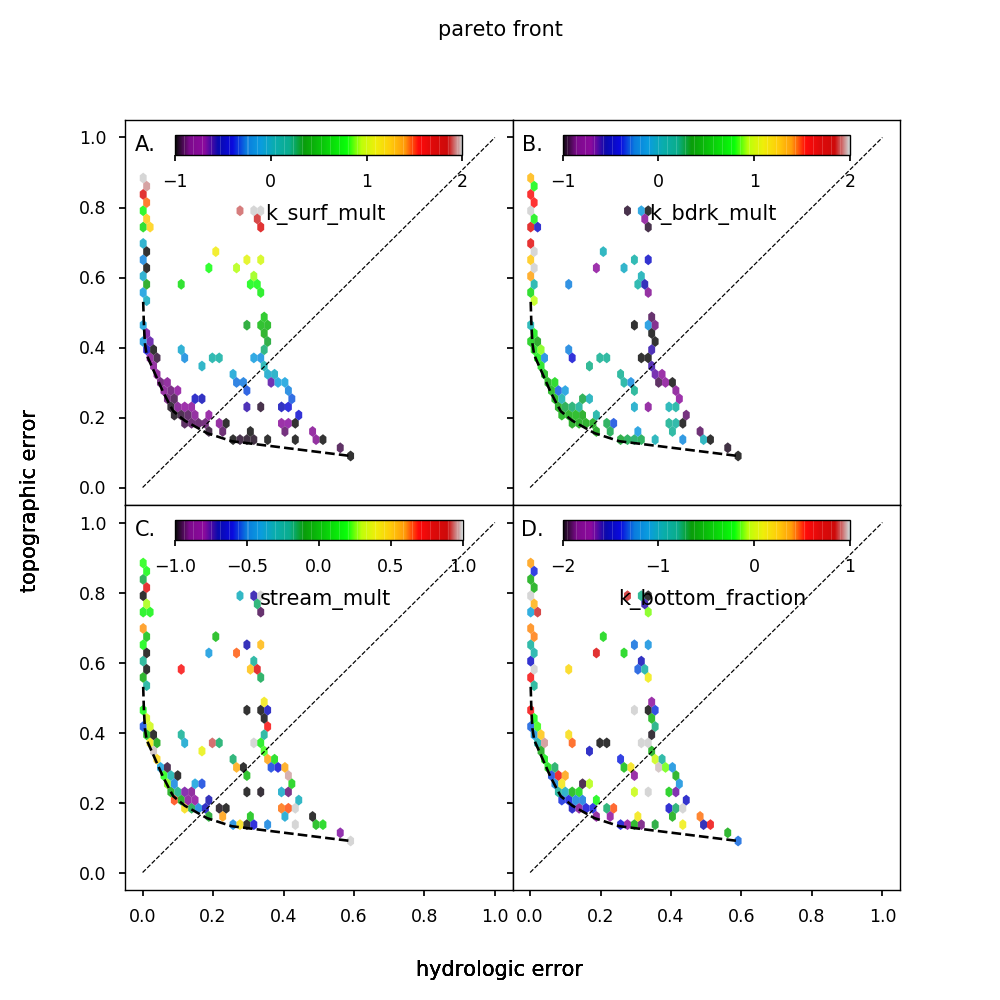

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharey=True,
                       gridspec_kw={'hspace': 0.0, 'wspace': 0})

axs = axs.ravel()

li = ['k_surf_mult', 'k_bdrk_mult', 'stream_mult', 'k_bottom_fraction']
letter = ['A.', 'B.', 'C.', 'D.']

for num in range(4):
    plot = axs[num]
    var = li[num]
    im = plot.hexbin(df.topo_error, df.hydro_error, df[var], 30, reduce_C_function=np.mean,
                   cmap=plt.cm.nipy_spectral, alpha=0.8, edgecolors='None')

#     im = sns.scatterplot(x='topo_error', y='hydro_error', data=df, ax=plot, s=5, edgecolor='none', color='k')

    pos = plot.get_position()
    cbaxes = fig.add_axes([pos.x0+0.05, pos.y0+0.35, pos.width - 0.1, 0.02]) 
    cb = plt.colorbar(im, ax=plot, cax=cbaxes, orientation='horizontal')  
    dum = fig.text(0.02, 0.5, 'topographic error', rotation='vertical', ha='left', va='center', fontsize=12)
    dum = fig.text(0.50, 0.02, 'hydrologic error', rotation='horizontal', ha='center', va='bottom', fontsize=12)
    dum = fig.text(pos.x0+0.20, pos.y0+0.28, var, rotation='horizontal', ha='center', va='bottom', fontsize=12)
    dum = fig.text(pos.x0+0.02, pos.y0+0.35, letter[num], rotation='horizontal', ha='center', va='bottom', fontsize=12)

    dum = plot.plot((0, 1), (0, 1), linestyle='dashed', color='black', linewidth=0.7)
    dum = plot.plot(*front.xy, linestyle='dashed', color='black', linewidth=1.5)
#     dum = sns.scatterplot(x='topo_error', y='hydro_error', ax=plot,
#                           data=df.iloc[pareto_sets], marker='s', edgecolor='None', color='k', **{'s': 30})
    dum = plot.grid(False)
    dum = fig.suptitle('pareto front')

plt.savefig(os.path.join('optimal_model', 'pareto_plot.png'))
    


<IPython.core.display.Javascript object>


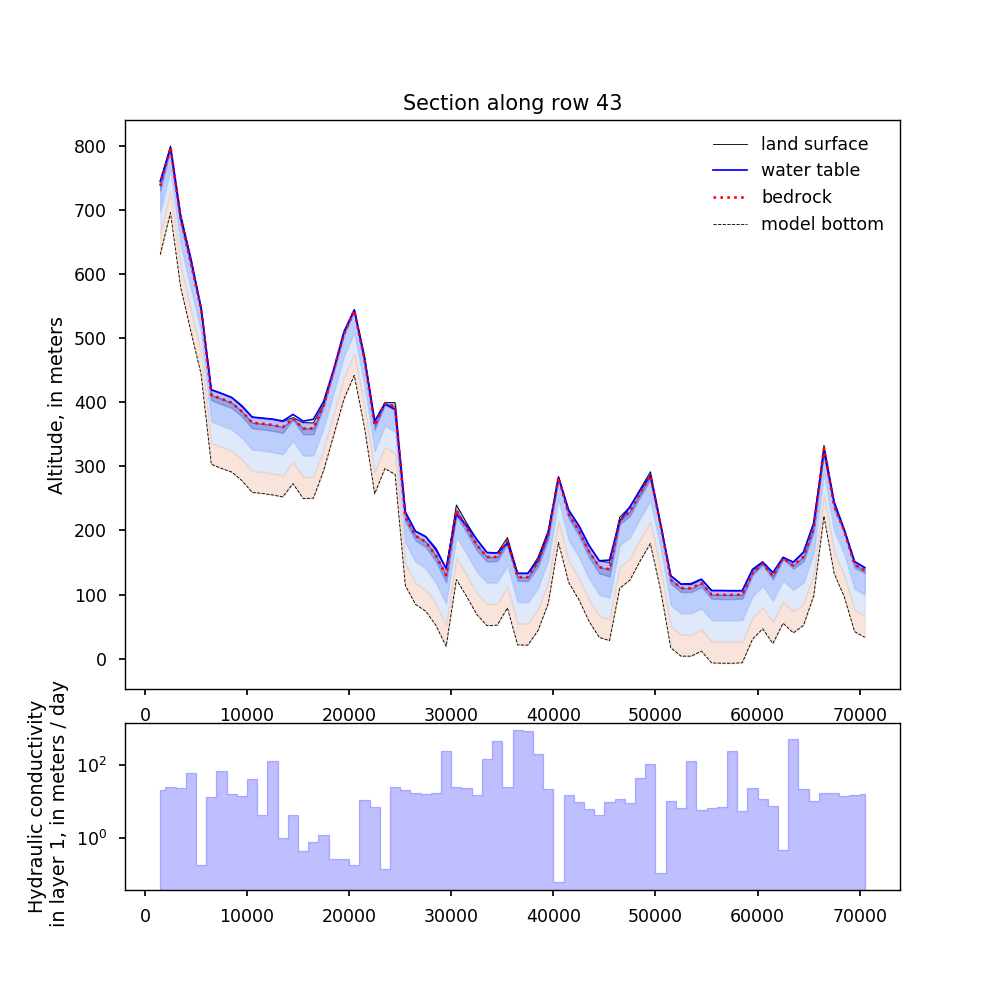

In [25]:
l, r, c = np.indices((nlay, nrow, ncol))

hin = np.argmax(np.isfinite(bedrock_index), axis=0)    
bedrock_top =  np.squeeze(botm[hin, r[0,:,:], c[0,:,:]])

NROW = nrow
NCOL = ncol

def ma2(data2D):
    return np.ma.MaskedArray(data2D, mask=(ibound[0, ...] == 0))


def ma3(data3D):
    return np.ma.MaskedArray(data3D, mask=(ibound == 0))


def interpolate_travel_times(points, values, xi):
    return si.griddata(points, values, xi, method='linear')


def plot_travel_times(ax, x, y, tt, shp):
    with np.errstate(invalid='ignore'):
        return ax.contourf(x.reshape(shp), y.reshape(shp), tt[:].reshape(shp),
                           colors=colors, alpha=1.0, levels=levels, antialiased=True)

row_to_plot = np.int32(NROW / 2)
# row_to_plot = 65
xplot = np.linspace(delc[0] / 2, NCOL * delc[0] - delc[0] / 2, NCOL)

mKh = ma3(k)
mtop = ma2(top.reshape(nrow, ncol))
mbed = ma2(bedrock_top)
mbot = ma3(botm)

rtd = rtd_ut.RTD_util(sim, 'flow', 'rt')
rtd.get_watertable()
water_table = rtd.water_table

# lay_colors = ['green', 'red', 'gray']
# make a color map of fixed colors
cmap = plt.cm.coolwarm
bounds = [0, 5, 10]
norm = colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)

dum = ax1.plot(xplot, mtop[row_to_plot, ],
               label='land surface', color='black', lw=0.5)
dum = ax1.plot(xplot, rtd.water_table[row_to_plot, ],
               label='water table', color='blue', lw=1.)
dum = ax1.fill_between(xplot, mtop[row_to_plot, ], mbot[0, row_to_plot, :], alpha=0.25,
                       color='blue', lw=0.75)
for lay in range(nlay-1):
    label = 'layer {}'.format(lay+2)
    dum = ax1.fill_between(xplot, mbot[lay, row_to_plot, :], mbot[lay+1, row_to_plot, :],
                           color=cmap(lay / nlay), alpha=0.50, lw=0.75)
dum = ax1.plot(xplot, mbed[row_to_plot, :], label='bedrock',
               color='red', linestyle='dotted', lw=1.5)
dum = ax1.plot(xplot, mbot[-1, row_to_plot, :], color='black',
               linestyle='dashed', lw=0.5, label='model bottom')

dum = ax1.legend(loc=0, frameon=False, fontsize=10, ncol=1)
dum = ax1.set_ylabel('Altitude, in meters')
# dum = ax1.set_xticklabels('')
dum = ax1.set_title('Section along row {}'.format(row_to_plot))

ax2 = plt.subplot2grid((4, 1), (3, 0))
dum = ax2.fill_between(xplot, 0, mKh[0, row_to_plot, :], alpha=0.25, color='blue',
                 label='layer 1', lw=0.75, step='mid')
dum = ax1.set_xlabel('Distance in meters')
dum = ax2.set_yscale('log')
dum = ax2.set_ylabel('Hydraulic conductivity\n in layer 1, in meters / day')

line = 'optimal_{}_xs.png'.format(metadata['HUC8_name'])
fig_name = os.path.join('optimal_model', line)
plt.savefig(fig_name)

<IPython.core.display.Javascript object>


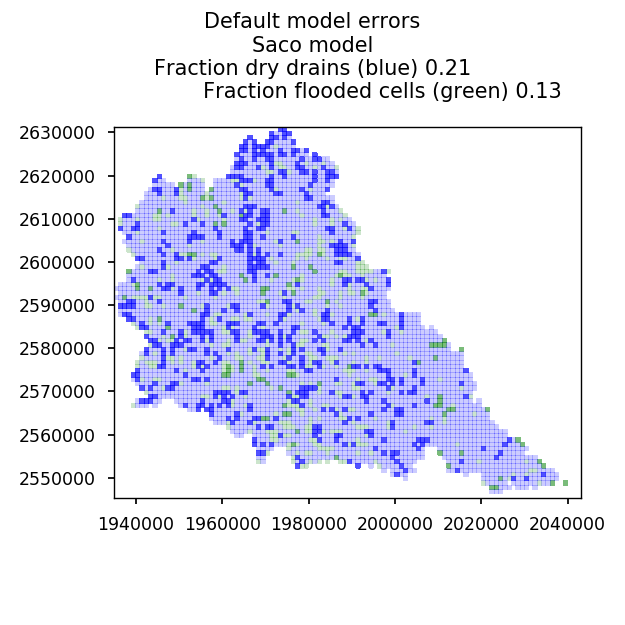

In [30]:
grid = os.path.join(metadata['gis_dir'], 'ibound.tif')
mtg = gmu.SourceProcessing(np.nan)
mtg.read_raster(grid)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

t_crit = (model_grid.obs_type =='topo') & (ibound[0, ...].ravel() != 0)
topo_cells = t_crit.values.reshape(NROW, NCOL)

h_crit = (model_grid.obs_type =='hydro') & (ibound[0, ...].ravel() != 0)
hydro_cells = h_crit.values.reshape(NROW, NCOL)

num_topo = np.count_nonzero(topo_cells)
num_hydro = np.count_nonzero(hydro_cells)

topo = (top + meta.err_tol) < water_table
hydro = (top - meta.err_tol) > water_table

topo_error = topo & topo_cells
hydro_error = hydro & hydro_cells

mask = (ibound[0] == 0) | ~topo_cells
mt = np.ma.MaskedArray(topo_cells, mask)
cmap = colors.ListedColormap(['green'])
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mt, cmap=cmap, alpha=0.2, edgecolors=None)
mask = (ibound[0] == 0) | ~topo_error
mte = np.ma.MaskedArray(topo_error, mask)
cmap = colors.ListedColormap(['green'])
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mte, cmap=cmap, alpha=0.4, edgecolors=None)

mask = (ibound[0] == 0) | ~hydro_cells
mh = np.ma.MaskedArray(hydro_cells, mask)
cmap = colors.ListedColormap(['blue'])
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mh, cmap=cmap, alpha=0.2, edgecolors=None)
mask = (ibound[0] == 0) | ~hydro_error
mhe = np.ma.MaskedArray(hydro_error, mask)
cmap = colors.ListedColormap(['blue'])
im = ax.pcolormesh(mtg.x_edge, mtg.y_edge, mhe, cmap=cmap, alpha=0.6, edgecolors=None)

ax.set_aspect(1)

dum = fig.suptitle('Default model errors\n{} model\nFraction dry drains (blue) {:0.2f}\n \
                    Fraction flooded cells (green) {:0.2f}'.format( \
 metadata['HUC8_name'], hydro_rate, topo_rate))
fig.set_tight_layout(True)

line = 'optimal_{}_error_map.png'.format(metadata['HUC8_name'])   #csc
fig_name = os.path.join('optimal_model', line)
plt.savefig(fig_name)

mtg.old_raster = topo_error
line = os.path.join('optimal_model', 'topo_error.tif')
mtg.write_raster(line)

mtg.old_raster = hydro_error
line = os.path.join('optimal_model', 'hydro_error.tif')
mtg.write_raster(line)



<IPython.core.display.Javascript object>


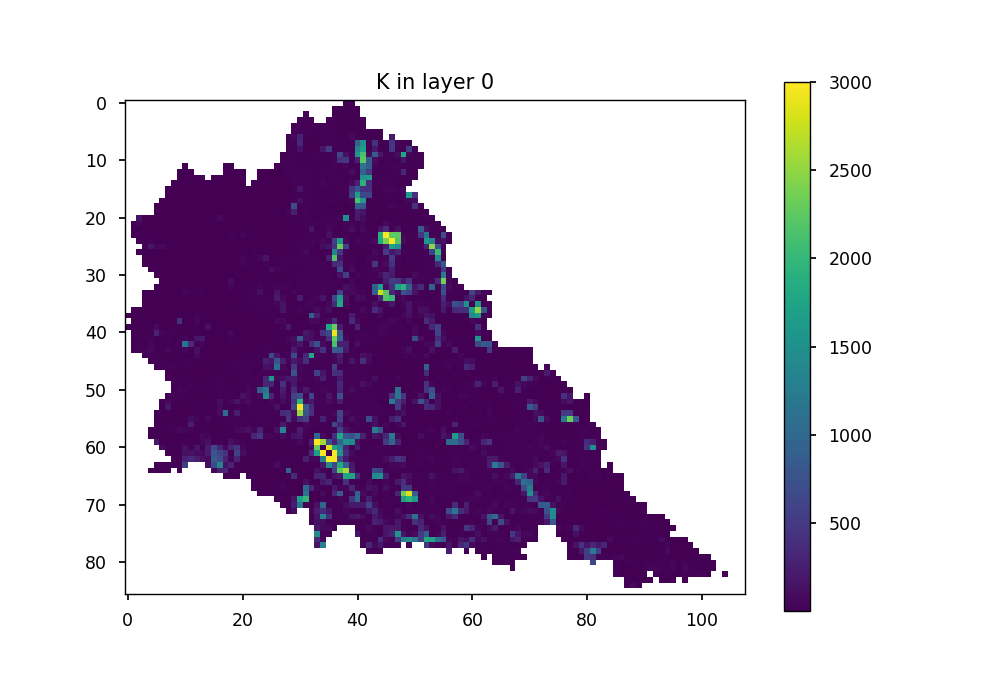

Text(0.5, 1.0, 'K in layer 0')

<IPython.core.display.Javascript object>


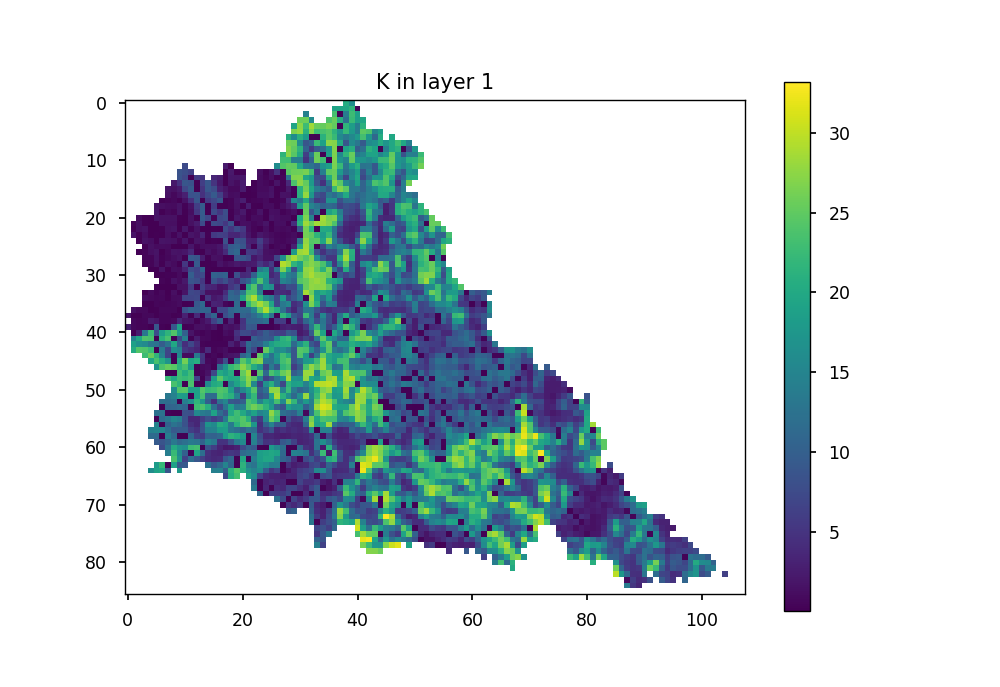

Text(0.5, 1.0, 'K in layer 1')

<IPython.core.display.Javascript object>


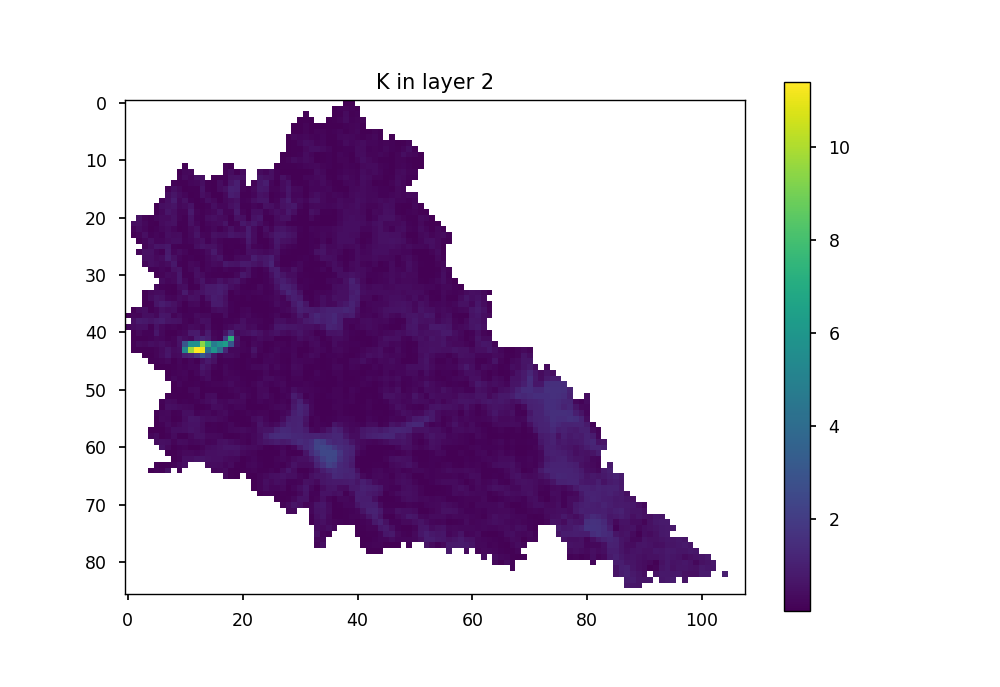

Text(0.5, 1.0, 'K in layer 2')

<IPython.core.display.Javascript object>


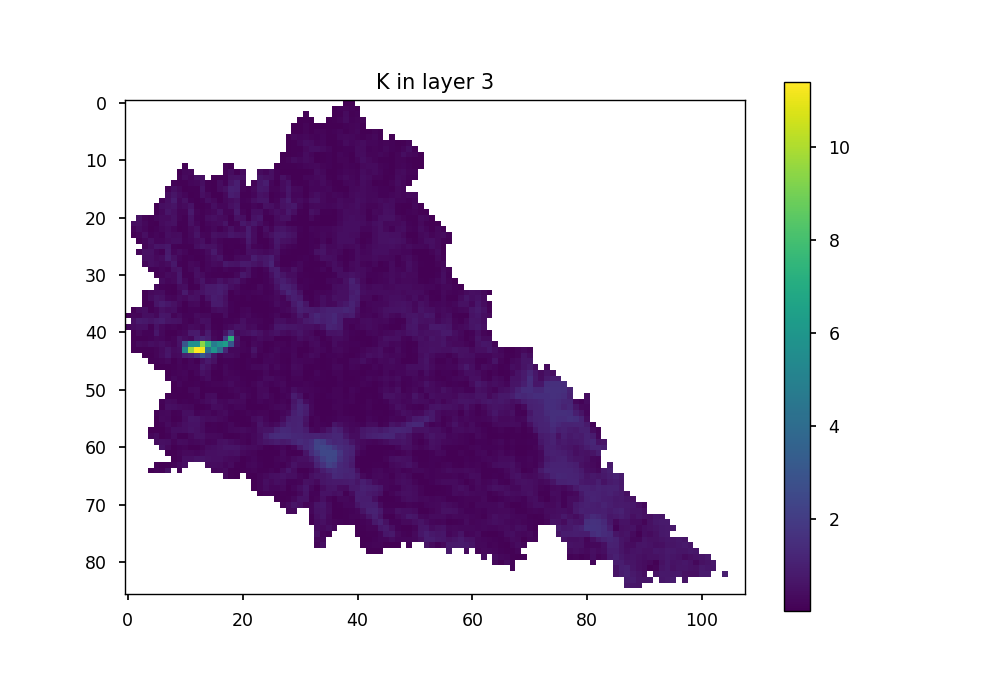

Text(0.5, 1.0, 'K in layer 3')

<IPython.core.display.Javascript object>


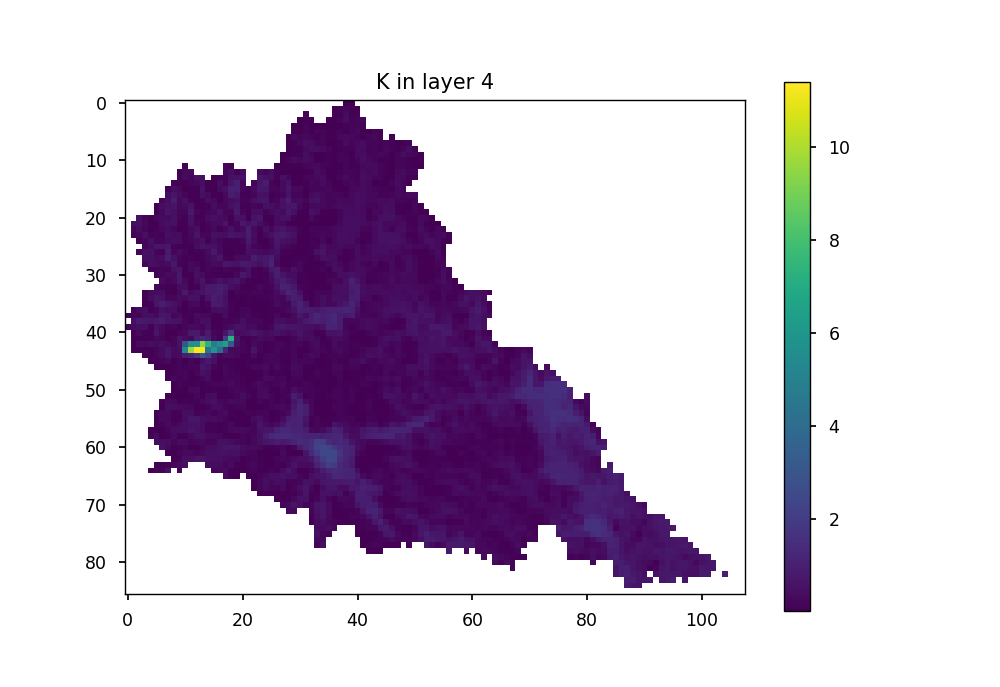

Text(0.5, 1.0, 'K in layer 4')

In [27]:
k[ibound == 0] = np.nan

for layer in range(nlay):
    fig, ax = plt.subplots(1, 1)
    im = ax.imshow(k[layer, ...])
    ax.set_title('K in layer {}'.format(layer))
    fig.colorbar(im)
    mtg.old_raster = k[layer, ...]
    line = os.path.join('optimal_model', 'k_layer_{}.tif'.format(layer))
    mtg.write_raster(line)

In [28]:
mtg.old_raster = water_table
line = os.path.join('optimal_model', 'water_table.tif')
mtg.write_raster(line)